# Predicting energy production on a subset of the texas electricity grid:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook 

import os.path
import datetime as dt
import keras
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import sklearn as sk
import sklearn.preprocessing as proc
from keras.utils import plot_model
import pydot
import tensorflow as tf
import graphviz

Using TensorFlow backend.


In [2]:
# this function expands the data so the lstm is fed short time series sequences
def expand_data(xdata,timesteps):

    data_shape=(xdata.shape[0],timesteps,xdata.shape[1])   # define shape of expanded data to include repeated timesteps 
    
    x_large = np.zeros(data_shape)
    
    for i in range(timesteps,xdata.shape[0]-1):
        for j in range(0,timesteps):
            x_large[i,j,:]=xdata[i-timesteps+j,:]
            #x_large[i,j,:]=xdata[i-j,:] # reversed version

            

    return x_large


In [3]:
#cleans data by dropping features and creating year, day, hour features and creating y-labels       
def clean_data(data):

    drop_features=['PCP06','PCP24','SKC','GUS']     # drop dirty or non-important data columns
    data_pruned=data.drop(drop_features, axis=1) 

    data_pruned['DateTime']=pd.to_datetime(data_pruned['DateTime']) # cast the date time column to datetime format

    data_pruned=data_pruned.set_index('DateTime')   #sets index as a datetime index
    data_pruned['DateTime']=data_pruned.index       # datetime column is also set to index, i had to do this because DateTime was removed by set_index 

    data_resampled=data_pruned.resample('H').mean()     # resample data by the hour
    data_resampled=data_resampled.fillna(method='pad')  # fills empty values by filling in with previous values. this needs to be improved

    data_resampled['DateTime']=data_resampled.index     #creates a DateTime column from the datetime index

    #add columns for year, year day, and hour
    data_resampled['year'] = data_resampled['DateTime'].apply(lambda x: x.timetuple().tm_year-2014)
    data_resampled['y_day'] = data_resampled['DateTime'].apply(lambda x: x.timetuple().tm_yday)
    data_resampled['hour'] = data_resampled['DateTime'].apply(lambda x: x.timetuple().tm_hour)

    data_resampled=data_resampled.drop('DateTime',axis=1)   #drop the datetime column


    #shifting data to create y labels 
    #columnsDA = [col for col in data_resampled.columns if "RealTime" in col]

    shifted_realtime=data_resampled[['HB_NORTH_RealTime','LZ_RAYBN_RealTime']].shift(-1,freq='24H')   #shifts grid data forward 24 hours
    shifted_realtime.columns=['HB_NORTH_24H','LZ_RAYBN_24H']    # names columns

    #merge input data with y labels to create a full dataset
    full_data=pd.merge(data_resampled,shifted_realtime,how='inner',left_index=True,right_index=True) 



    full_data=full_data.fillna(0) #fill nas with 0
    print(full_data.columns)
    full_data=full_data.drop(['EB1_MNSES_RealTime','Unnamed: 0','USAF'],axis=1) 


    return full_data

In [4]:
def clean_data_diff(df):
    df.DateTime = pd.to_datetime(df.DateTime)
    
    df["HB_NORTH_Difference"] = df.HB_NORTH_RealTime - df.HB_NORTH_DayAhead
    df['LZ_RAYBN_Difference'] = df.LZ_RAYBN_RealTime - df.LZ_RAYBN_DayAhead
    df.AMELIA2_8W_DayAhead[0] = df.AMELIA2_8W_DayAhead.iloc[1]
    df = df.drop(["EB1_MNSES_RealTime", "WOODROW69W_RealTime", "WOODROW69W_DayAhead", "PCP06", "PCP24"], 1)
    df.DIR = df.DIR.fillna(int(df.DIR.mode()))
    df.SPD = df.SPD.fillna(df.SPD.median())
    df.GUS = df.GUS.fillna(0)
    df.CLG = df.CLG.fillna(method="bfill")
    df.SLP = df.SLP.fillna(method="bfill")
    df.ALT = df.ALT.fillna(method="bfill")
    df.SKC = df.SKC.fillna(-5)
    df.STP = df.STP.fillna(method="bfill")
    mapping = {'CLR': 0, 'OBS': 1, 'SCT':2, 'BKN':3, 'OVC': 4}
    df = df.replace({'SKC': mapping})
    
    df['year'] = df['DateTime'].apply(lambda x: x.timetuple().tm_year-2014)
    df['y_day'] = df['DateTime'].apply(lambda x: x.timetuple().tm_yday)
    df['hour'] = df['DateTime'].apply(lambda x: x.timetuple().tm_hour)
    df=df.set_index('DateTime')
    mapping = {'N':0, 'Y':1}
    df = df.replace({"DaylightSavings": mapping})
    #Scaling
    #df = (df - df.mean())/df.std()#(df.max() - df.min())
    """ 
    print("in clean_data_diff pre shift, dim = ", df.shape)
    
    shifted_realtime=df[['HB_NORTH_RealTime','LZ_RAYBN_RealTime', 'HB_NORTH_Difference', 'LZ_RAYBN_Difference']].shift(-1,freq='24H')   #shifts grid data forward 24 hours
    shifted_realtime.columns=['HB_NORTH_24H_RT','LZ_RAYBN_24H_RT','HB_NORTH_24H_DF','LZ_RAYBN_24H_DF']    # names columns
    
    print("in clean_data_diff post shift, dim = ", shifted_realtime.shape)

    #merge input data with y labels to create a full dataset
    df=pd.merge(df,shifted_realtime,how='inner',left_index=True,right_index=True) 
    #df = df.drop(['HB_NORTH_RealTime','LZ_RAYBN_RealTime', 'HB_NORTH_Difference', 'LZ_RAYBN_Difference'], 1)"""

    
    df = df.drop([col for col in df.columns if "DayAhead" in col], 1)
    return df

In [5]:

#function that takes a cleaned dataframe that includes y labels and outputs scaled and normalized
#data that is in the correct format for keras LSTM. Also splits test data

def preprocess_data(data, lookback, final_test):
    x = data.drop(['HB_NORTH_RealTime','LZ_RAYBN_RealTime'], 1)
    y = data[['HB_NORTH_RealTime','LZ_RAYBN_RealTime']]
    x_scaler = proc.StandardScaler().fit(x)
    x = x_scaler.transform(x)
    #x_train=proc.scale(x_train,axis=0) #scale data so it is zero mean and unit variance
    y_scaler = proc.StandardScaler().fit(y)
    y = y_scaler.transform(y)
    #x_train=proc.scale(x_train,axis=0) #scale data so it is zero mean and unit variance
    
    holder=expand_data(np.array(x),lookback) 
    
    if final_test:
        
        test_split = 24000
        x_train=holder[lookback:test_split,:,:]
        x_test=holder[test_split:(len(full_data) - 24),:,:]

        #x_train = x.iloc[:, :]
        y_train = y[(lookback + 24):(test_split + 24), :]
        #x_test = x.iloc[19000:,]
        y_test = y[(test_split + 24):,:]
    else:
        test_split = 19000
        x_train=holder[lookback:test_split,:,:]
        x_test=holder[test_split:24000,:,:]

        #x_train = x.iloc[:, :]
        y_train = y[(lookback + 24):(test_split + 24), :]
        #x_test = x.iloc[19000:,]
        y_test = y[(test_split + 24):(24000 + 24),]
    print("dim of full_data: ", full_data.shape)
    print("dim x_train: ", x_train.shape, "dim y_train: ", y_train.shape, "dim x_test: ", x_test.shape, "dim y test: ", y_test.shape)
    return (x_train,y_train,x_test,y_test, y_scaler)

# Loading and cleaning data:

In [6]:
data=pd.read_csv('cleaned_data/all_the_data.csv', index_col=0)  # reads merged 



hb_da = data[['HB_NORTH_DayAhead','LZ_RAYBN_DayAhead']]
#test_DA = full_data[['HB_NORTH_DayAhead','LZ_RAYBN_DayAhead']].iloc[19000:24000, :]

full_data=clean_data_diff(data)


full_data = full_data.drop([#'HB_NORTH_24H_DF','LZ_RAYBN_24H_DF', 
                            #'HB_NORTH_RealTime','LZ_RAYBN_RealTime', 
                            'HB_NORTH_Difference', 'LZ_RAYBN_Difference'], 1)
#test_DA = full_data[['HB_NORTH_DayAhead','LZ_RAYBN_DayAhead']].iloc[19000:24000, :]
#full_data.iloc[24000, :]



/Users/davisdulin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Reshaping data so it is compatible with keras

In [7]:
scale=1

# reshape data
timesteps=1;    #leave this as 1 for now
lookback=1  #the number of hours in the past that the lstm looks at

time=full_data.index #create an index for time that we can use to plot things

x_train, y_train, x_test, y_test, y_scaler = preprocess_data(full_data, lookback, False)
test_split = 19000

#plt.figure()
#plt.plot(pd.to_datetime(full_data.index), hb_da['HB_NORTH_DayAhead'], pd.to_datetime(full_data.index), full_data.HB_NORTH_RealTime)
#plt.show()

dim of full_data:  (28650, 72)
dim x_train:  (18999, 1, 70) dim y_train:  (18999, 2) dim x_test:  (5000, 1, 70) dim y test:  (5000, 2)


# Keras Neural Network Design, Training, and Prediction

In [8]:
# design network
input_shape=(x_train.shape[1], x_train.shape[2])

model = Sequential()

#network layers###########################

model.add(LSTM(25,return_sequences=True,input_shape=input_shape,activation='selu'))

#model.add(keras.layers.LeakyReLU())

model.add(LSTM(10))
model.add(keras.layers.LeakyReLU(alpha=0.3))
model.add(Dense(10))
model.add(keras.layers.LeakyReLU(alpha=0.3))
model.add(Dense(5))
model.add(keras.layers.LeakyReLU(alpha=0.3))

#model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(Dense(2))
model.add(keras.layers.LeakyReLU(alpha=0.3))

#model.add(keras.layers.LeakyReLU(alpha=0.3))

#network compiling#########################

model.compile(loss='mean_absolute_error', optimizer='adam')
#categorical_hinge is the only loss that results in (poor) negative predictions
#logcosh performs better than we have yet seen on some parts of the test dataset, and very poorly on other parts.

#fit network
history = model.fit(x_train, 
                    y_train,#[0::timesteps], 
                    epochs=50, 
                    batch_size=1000, 
                    validation_split=0.1,
                    verbose=2, 
                    shuffle=False)

Train on 17099 samples, validate on 1900 samples
Epoch 1/50
 - 4s - loss: 0.3888 - val_loss: 0.5206
Epoch 2/50
 - 0s - loss: 0.3774 - val_loss: 0.5053
Epoch 3/50
 - 0s - loss: 0.3641 - val_loss: 0.4814
Epoch 4/50
 - 0s - loss: 0.3425 - val_loss: 0.4371
Epoch 5/50
 - 0s - loss: 0.3133 - val_loss: 0.3572
Epoch 6/50
 - 0s - loss: 0.2880 - val_loss: 0.2730
Epoch 7/50
 - 0s - loss: 0.2848 - val_loss: 0.2510
Epoch 8/50
 - 0s - loss: 0.2817 - val_loss: 0.2571
Epoch 9/50
 - 0s - loss: 0.2799 - val_loss: 0.2502
Epoch 10/50
 - 0s - loss: 0.2788 - val_loss: 0.2493
Epoch 11/50
 - 0s - loss: 0.2778 - val_loss: 0.2473
Epoch 12/50
 - 0s - loss: 0.2771 - val_loss: 0.2461
Epoch 13/50
 - 0s - loss: 0.2764 - val_loss: 0.2450
Epoch 14/50
 - 0s - loss: 0.2757 - val_loss: 0.2439
Epoch 15/50
 - 0s - loss: 0.2749 - val_loss: 0.2421
Epoch 16/50
 - 0s - loss: 0.2741 - val_loss: 0.2401
Epoch 17/50
 - 0s - loss: 0.2736 - val_loss: 0.2406
Epoch 18/50
 - 0s - loss: 0.2725 - val_loss: 0.2380
Epoch 19/50
 - 0s - loss

# predict and plot data

<IPython.core.display.Javascript object>


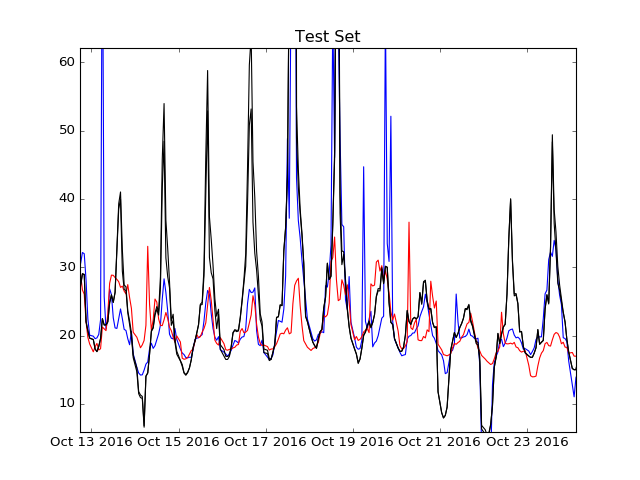

/Users/davisdulin/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [9]:
y_training_set_predictions=model.predict(x_train,batch_size=x_train.shape[0]) 
y_test_set_predictions=model.predict(x_test,batch_size=x_test.shape[0]) 

plt.figure()

plt.plot(time[test_split:24000],
         y_scaler.inverse_transform(y_test*scale)[:,0], color = "blue")
plt.plot(time[test_split:24000],
         y_scaler.inverse_transform(y_test_set_predictions*scale)[:,0], color = "red")
plt.plot(time[test_split:24000],
         hb_da.as_matrix()[test_split+24:24000+24], color = "black")#,
         #color=("blue", "red", "black")
#        )

plt.title("Test Set")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


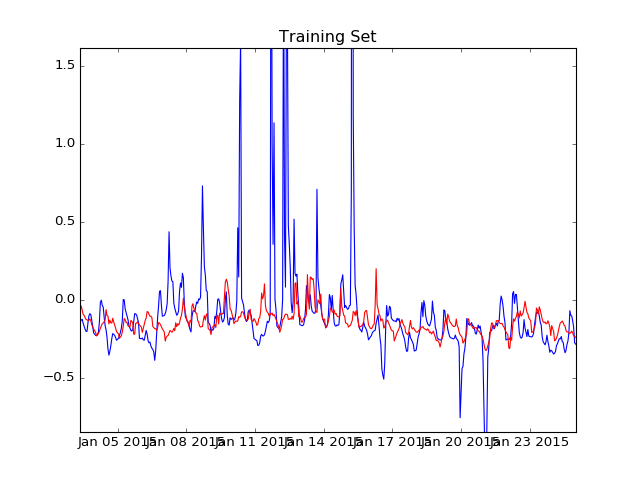

In [10]:

plt.figure()
plt.plot(time[lookback:test_split],
         y_train[:,0],
        color = "blue")
plt.plot(time[lookback:test_split],
         y_training_set_predictions[:,0],
         color = "red"
        )
plt.title("Training Set")

<IPython.core.display.Javascript object>


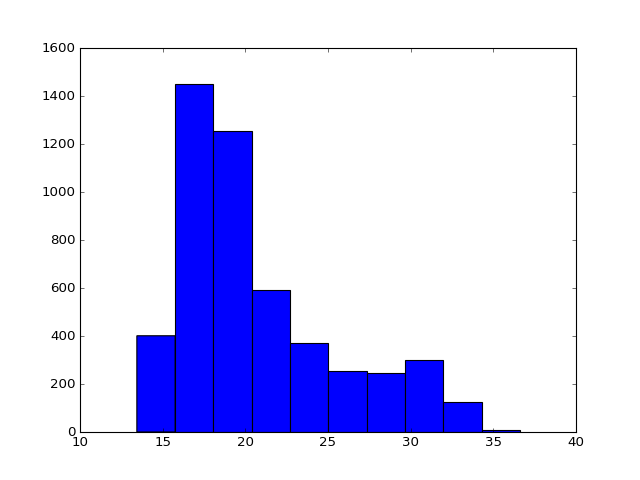

/Users/davisdulin/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [11]:
plt.figure()
plt.hist(y_scaler.inverse_transform(y_test_set_predictions*scale)[:,0])
plt.legend()
plt.show()


In [12]:
avg_err_model = sum(np.absolute(y_scaler.inverse_transform(y_test_set_predictions*scale) - y_scaler.inverse_transform(y_test*scale)))/len(y_test_set_predictions)

In [13]:
avg_err_utility = sum(np.absolute(hb_da.as_matrix()[test_split+24:24000+24] - y_scaler.inverse_transform(y_test*scale)))/len(hb_da.as_matrix()[test_split+24:24000+24])

In [20]:
avg_err_model = sum(np.absolute(y_scaler.inverse_transform(y_test_set_predictions*scale) - y_scaler.inverse_transform(y_test*scale)))/len(y_test_set_predictions)
avg_err_utility = sum(np.absolute(hb_da.as_matrix()[test_split+24:24000+24] - y_scaler.inverse_transform(y_test*scale)))/len(hb_da.as_matrix()[test_split+24:24000+24])

print("average error of the model: ", avg_err_model)
print("average error of utility predictions: ", avg_err_utility)
print("average performance of our model over the utility predictions:", sum(avg_err_utility - avg_err_model)/2)
both = (y_scaler.inverse_transform(y_test_set_predictions*scale) + hb_da.as_matrix()[test_split+24:24000+24])/2
avg_both = sum(np.absolute((both - y_scaler.inverse_transform(y_test*scale))))/len(y_test_set_predictions)
print("average error of ensemble: ", avg_both)

print("average performance of our ensemble over the utility predictions:", sum(avg_err_utility - avg_both)/2)
print("possible total savings of: $", 24*365*1300*sum(avg_err_utility - avg_both)/2)

average error of the model:  [ 5.31844537  5.69196002]
average error of utility predictions:  [ 6.1388135  6.400688 ]
average performance of our model over the utility predictions: 0.764548058178
average error of ensemble:  [ 4.93488694  5.21507518]
average performance of our ensemble over the utility predictions: 1.19476968823
possible total savings of: $ 13606037.2096


In [15]:
"""avg_diff_of_avg = []
losses = ['mean_squared_error', 
          'mean_absolute_error', 
          'mean_absolute_percentage_error', 
          'mean_squared_logarithmic_error', 
          'squared_hinge', 
          'hinge',
          'categorical_hinge',
          'logcosh',
          'categorical_crossentropy',
          'kullback_leibler_divergence',
          'poisson',
          'cosine_proximity']

for i in losses:
    print(i)
    # design network
    input_shape=(x_train.shape[1], x_train.shape[2])

    model = Sequential()

    #network layers###########################

    model.add(LSTM(25,return_sequences=True,input_shape=input_shape,activation='selu'))

    #model.add(keras.layers.LeakyReLU())

    model.add(LSTM(10))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dense(10))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dense(5))
    model.add(keras.layers.LeakyReLU(alpha=0.3))

    #model.add(keras.layers.LeakyReLU(alpha=0.3))

    model.add(Dense(2))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    model.compile(loss=i, optimizer='adam')
    history = model.fit(x_train, 
                    y_train,#[0::timesteps], 
                    epochs=50, 
                    batch_size=1000, 
                    validation_split=0.1,
                    verbose=0, 
                    shuffle=False)
    
    y_training_set_predictions=model.predict(x_train,batch_size=x_train.shape[0]) 
    y_test_set_predictions=model.predict(x_test,batch_size=x_test.shape[0]) 
    avg_err_model = sum(np.absolute(y_scaler.inverse_transform(y_test_set_predictions*scale) - y_scaler.inverse_transform(y_test*scale)))/len(y_test_set_predictions)
    avg_err_utility = sum(np.absolute(hb_da.as_matrix()[test_split+24:24000+24] - y_scaler.inverse_transform(y_test*scale)))/len(hb_da.as_matrix()[test_split+24:24000+24])
    avg_diff_of_avg.append(sum(avg_err_model - avg_err_utility)/2)"""


"avg_diff_of_avg = []\nlosses = ['mean_squared_error', \n          'mean_absolute_error', \n          'mean_absolute_percentage_error', \n          'mean_squared_logarithmic_error', \n          'squared_hinge', \n          'hinge',\n          'categorical_hinge',\n          'logcosh',\n          'categorical_crossentropy',\n          'kullback_leibler_divergence',\n          'poisson',\n          'cosine_proximity']\n\nfor i in losses:\n    print(i)\n    # design network\n    input_shape=(x_train.shape[1], x_train.shape[2])\n\n    model = Sequential()\n\n    #network layers###########################\n\n    model.add(LSTM(25,return_sequences=True,input_shape=input_shape,activation='selu'))\n\n    #model.add(keras.layers.LeakyReLU())\n\n    model.add(LSTM(10))\n    model.add(keras.layers.LeakyReLU(alpha=0.3))\n    model.add(Dense(10))\n    model.add(keras.layers.LeakyReLU(alpha=0.3))\n    model.add(Dense(5))\n    model.add(keras.layers.LeakyReLU(alpha=0.3))\n\n    #model.add(keras.layer

In [16]:
x_train_final, y_train_final, x_test_final, y_test_final, y_scaler = preprocess_data(full_data, lookback, True)


dim of full_data:  (28650, 72)
dim x_train:  (23999, 1, 70) dim y_train:  (23999, 2) dim x_test:  (4626, 1, 70) dim y test:  (4626, 2)


# Final Prediction on Test Set:

In [17]:
x_train_final, y_train_final, x_test_final, y_test_final, y_scaler = preprocess_data(full_data, lookback, True)
# design network
input_shape=(x_train_final.shape[1], x_train_final.shape[2])

model = Sequential()

#network layers###########################

model.add(LSTM(25,return_sequences=True,input_shape=input_shape,activation='selu'))

#model.add(keras.layers.LeakyReLU())

model.add(LSTM(10))
model.add(keras.layers.LeakyReLU(alpha=0.3))
model.add(Dense(10))
model.add(keras.layers.LeakyReLU(alpha=0.3))
model.add(Dense(5))
model.add(keras.layers.LeakyReLU(alpha=0.3))

#model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(Dense(2))
model.add(keras.layers.LeakyReLU(alpha=0.3))

#model.add(keras.layers.LeakyReLU(alpha=0.3))

#network compiling#########################

model.compile(loss='mean_absolute_error', optimizer='adam')
#categorical_hinge is the only loss that results in (poor) negative predictions
#logcosh performs better than we have yet seen on some parts of the test dataset, and very poorly on other parts.

#fit network
history = model.fit(x_train_final, 
                    y_train_final,#[0::timesteps], 
                    epochs=50, 
                    batch_size=1000, 
                    validation_split=0.1,
                    verbose=2, 
                    shuffle=False)
y_training_set_predictions_final = model.predict(x_train_final,batch_size=x_train_final.shape[0]) 
y_test_set_predictions_final = model.predict(x_test_final,batch_size=x_test_final.shape[0]) 

dim of full_data:  (28650, 72)
dim x_train:  (23999, 1, 70) dim y_train:  (23999, 2) dim x_test:  (4626, 1, 70) dim y test:  (4626, 2)
Train on 21599 samples, validate on 2400 samples
Epoch 1/50
 - 4s - loss: 0.4061 - val_loss: 0.3620
Epoch 2/50
 - 0s - loss: 0.3859 - val_loss: 0.3488
Epoch 3/50
 - 0s - loss: 0.3696 - val_loss: 0.3272
Epoch 4/50
 - 0s - loss: 0.3435 - val_loss: 0.2878
Epoch 5/50
 - 0s - loss: 0.2992 - val_loss: 0.2441
Epoch 6/50
 - 0s - loss: 0.2751 - val_loss: 0.2457
Epoch 7/50
 - 0s - loss: 0.2700 - val_loss: 0.2373
Epoch 8/50
 - 0s - loss: 0.2658 - val_loss: 0.2411
Epoch 9/50
 - 0s - loss: 0.2645 - val_loss: 0.2392
Epoch 10/50
 - 0s - loss: 0.2634 - val_loss: 0.2381
Epoch 11/50
 - 0s - loss: 0.2642 - val_loss: 0.2381
Epoch 12/50
 - 0s - loss: 0.2624 - val_loss: 0.2397
Epoch 13/50
 - 0s - loss: 0.2628 - val_loss: 0.2388
Epoch 14/50
 - 0s - loss: 0.2617 - val_loss: 0.2395
Epoch 15/50
 - 0s - loss: 0.2615 - val_loss: 0.2391
Epoch 16/50
 - 0s - loss: 0.2605 - val_loss: 

(4626,)
(4626, 2)
(4626, 2)


<IPython.core.display.Javascript object>


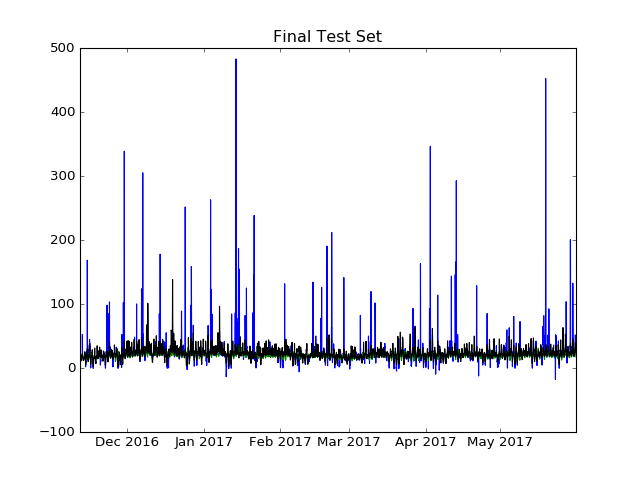

/Users/davisdulin/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [18]:
print(time[24000 +24:].shape)
print(y_test_final.shape)
print(y_test_set_predictions_final.shape)
plt.figure()

plt.plot(time[24000 +24:],
         y_scaler.inverse_transform(y_test_final*scale)[:,0], color = "blue")
plt.plot(time[24000+24:],
         y_scaler.inverse_transform(y_test_set_predictions_final*scale)[:,0], color = "green")
plt.plot(time[24000 + 24:],
         hb_da.as_matrix()[24000+24:][:,0], color = "black")#,
         #color=("blue", "red", "black")
#        )

plt.title("Final Test Set")
plt.legend()
plt.show()

In [19]:
avg_err_model = sum(np.absolute(y_scaler.inverse_transform(y_test_set_predictions_final*scale) - y_scaler.inverse_transform(y_test_final*scale)))/len(y_test_set_predictions)
avg_err_utility = sum(np.absolute(hb_da.as_matrix()[24000+24:] - y_scaler.inverse_transform(y_test_final*scale)))/len(hb_da.as_matrix()[24000+24:])

print("average error of the model: ", avg_err_model)
print("average error of utility predictions: ", avg_err_utility)
print("average performance of our model over the utility predictions:", sum(avg_err_utility - avg_err_model)/2)
both = (y_scaler.inverse_transform(y_test_set_predictions_final*scale) + hb_da.as_matrix()[24000+24:])/2
avg_both = sum(np.absolute((both - y_scaler.inverse_transform(y_test_final*scale))))/len(y_test_set_predictions_final)
print("average error of ensemble: ", avg_both)

print("average performance of our ensemble over the utility predictions:", sum(avg_err_utility - avg_both)/2)
print("possible total savings of: ", 24*365*1300*sum(avg_err_utility - avg_both)/2)

average error of the model:  [ 5.82692965  5.87901525]
average error of utility predictions:  [ 6.1686284   6.34085225]
average performance of our model over the utility predictions: 0.401767879112
average error of ensemble:  [ 5.62405095  5.73713647]
average performance of our ensemble over the utility predictions: 0.574146617159
possible total savings of:  6538381.6762
